In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from tqdm import tqdm
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from syd import Viewer

from vrAnalysis2.database import get_database
from vrAnalysis2.helpers import Timer
from vrAnalysis2.tracking import Tracker
from vrAnalysis2.multisession import MultiSessionSpkmaps
from vrAnalysis2.metrics import FractionActive

sessiondb = get_database('vrSessions')
mousedb = get_database('vrMice')
tracked_mice = mousedb.get_table(tracked=True)["mouseName"].unique()

In [ ]:
mouse = "CR_Hippocannula6"
tracker = Tracker(mouse)
msm = MultiSessionSpkmaps(tracker)
num_sessions = len(msm.processors)

def com(spkmap, positions):
    return np.nansum(spkmap * positions, axis=2) / np.nansum(spkmap, axis=2)
isession = 3
envnum = 2
spkmaps, extras = msm.get_spkmaps(envnum, average=False, tracked=False, idx_ses=[isession])
positions = extras["positions"]
reliability = extras["reliability"]
coms = [com(spkmap, positions) for spkmap in spkmaps]
fraction_active = [FractionActive.compute(spkmap, activity_axis=2, fraction_axis=1, activity_method="rms", fraction_method="participation") for spkmap in spkmaps]

C:\Users\Andrew\AppData\Local\Temp\ipykernel_5140\1686652951.py:7: RuntimeWarning: invalid value encountered in divide
  return np.sum(spkmap * positions, axis=2) / np.sum(spkmap, axis=2)


In [12]:
def get_com(spkmap, positions):
    return np.nansum(spkmap * positions, axis=2) / np.nansum(spkmap, axis=2)

def measure_r2_sse(x, y, slope, intercept):
    # Calculate predicted values
    r2 = np.zeros(len(slope))
    sse = np.zeros(len(slope))
    for i, (ss, ii) in enumerate(zip(slope, intercept)):
        mask = ~y[i].mask
        x_valid = x[mask]
        y_valid = y[i][mask]
        y_pred = ss * x_valid + ii
        
        # Calculate R²
        ss_total = np.sum((y_valid - np.mean(y_valid))**2)
        ss_residual = np.sum((y_valid - y_pred)**2)
        r2[i] = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
        sse[i] = ss_residual
    return r2, sse

def process_com(msm: MultiSessionSpkmaps):
    env_stats = msm.env_stats()
    mouse_data = {}
    for envnum in tqdm(env_stats, desc="Processing environments", leave=True):
        mouse_data[envnum] = {}
        for session in tqdm(env_stats[envnum], desc="Processing sessions for current environment", leave=False):
            mouse_data[envnum][session] = {}
            spkmaps, extras = msm.get_spkmaps(envnum, average=False, tracked=False, idx_ses=[session], pop_nan=False)
            spkmap = spkmaps[0]
            positions = extras["positions"]
            reliability = extras["reliability"][0]
            coms = get_com(spkmap, positions)
            fraction_active = FractionActive.compute(spkmap, activity_axis=2, fraction_axis=1, activity_method="rms", fraction_method="participation")

            active_trial_com = [com[~np.isnan(com)] for com in coms]
            difference_com = [np.diff(com) for com in active_trial_com]
            difference_com_mean = np.array([np.mean(com) for com in difference_com])
            difference_com_std = np.array([np.std(com) for com in difference_com])

            masked_coms = ma.masked_invalid(coms)
            trials = np.arange(masked_coms.shape[1])
            coeffs = []
            for com in masked_coms:
                if np.any(~com.mask):
                    try:
                        c_coeffs = np.ma.polyfit(trials, com, deg=1, full=False)
                    except np.linalg.LinAlgError:
                        c_coeffs = np.array([np.nan, np.nan])
                else:
                    c_coeffs = np.array([np.nan, np.nan])
                coeffs.append(c_coeffs)
            coeffs = np.stack(coeffs)
            r2, sse = measure_r2_sse(trials, masked_coms, coeffs[:, 0], coeffs[:, 1])

            mouse_data[envnum][session] = dict(
                coms=coms,
                fraction_active=fraction_active,
                reliability=reliability,
                active_trial_com=active_trial_com,
                difference_com=difference_com,
                difference_com_mean=difference_com_mean,
                difference_com_std=difference_com_std,
                slopes=coeffs[:, 0],
                intercepts=coeffs[:, 1],
                r2=r2,
                sse=sse,
            )

    return mouse_data

mouse_data = process_com(msm)

Processing environments:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Andrew\AppData\Local\Temp\ipykernel_5140\3676508765.py:2: RuntimeWarning: invalid value encountered in divide
  return np.nansum(spkmap * positions, axis=2) / np.nansum(spkmap, axis=2)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value enco

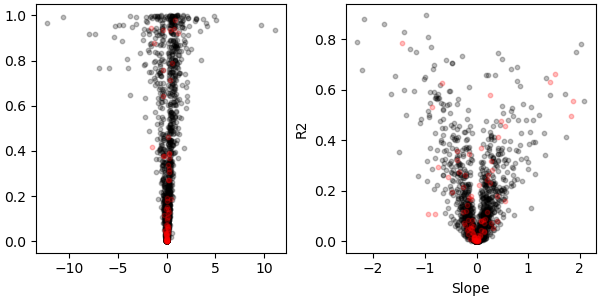

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")
for ienv, env in enumerate(mouse_data):
    for ises, ses in enumerate(mouse_data[env]):
        cslopes = mouse_data[env][ses]["slopes"]
        cr2 = mouse_data[env][ses]["r2"]
        cdiffcomstd = mouse_data[env][ses]["difference_com_std"]
        
        cidxgood = msm.processors[ses].session.idx_rois
        cidxred = msm.processors[ses].session.get_red_idx()[cidxgood]
        cidxactive = mouse_data[env][ses]["fraction_active"] > 0.1
        cidxreliable = mouse_data[env][ses]["reliability"] > 0.3
        prctile = np.nanpercentile(cdiffcomstd[cidxactive], 10)
        cidxsteady = cdiffcomstd <= prctile
        idx_keep = cidxactive & cidxsteady & cidxreliable
        ax[ienv].scatter(cslopes[~cidxred & idx_keep], cr2[~cidxred & idx_keep], c="k", s=10, alpha=0.25, zorder=0)
        ax[ienv].scatter(cslopes[cidxred & idx_keep], cr2[cidxred & idx_keep], c="r", s=10, alpha=0.25, zorder=1)

ax[1].set_xlabel("Slope")
ax[1].set_ylabel("R2")
plt.show()

In [40]:
from vrAnalysis2.helpers import named_transpose

class BTSPViewer(Viewer):
    def __init__(self, spkmap, com, reliability, fraction_active, positions):
        self.spkmap = spkmap
        self.com = com
        self.reliability = reliability
        self.fraction_active = fraction_active
        self.positions = positions
        bin_diff = positions[1] - positions[0]
        self.position_edges = np.append(positions[1:] - bin_diff / 2, positions[-1] + bin_diff / 2)
        self.active_trial_com = [com[~np.isnan(com)] for com in self.com]
        self.difference_com = [np.diff(com) for com in self.active_trial_com]
        self.difference_com_mean = np.array([np.mean(com) for com in self.difference_com])
        self.difference_com_std = np.array([np.std(com) for com in self.difference_com])

        self.reliability_default = (0.5, 1.0)
        self.fraction_active_default = (0.1, 1.0)
        
        self.add_float_range("reliability", value=self.reliability_default, min=-1.0, max=1.0, step=0.01)
        self.add_float_range("fraction_active", value=self.fraction_active_default, min=0.0, max=1.0, step=0.01)
        self.add_float_range("diffcomstd_percentile", value=(0.0, 100.0), min=0.0, max=100.0, step=0.1)

        self.add_integer("roi", value=0, min=0, max=1)
        self.add_float("vmax", value=5.0, min=0.0, max=20.0, step=0.1)

        self.on_change(["reliability", "fraction_active", "diffcomstd_percentile"], self.reset_selection)
        self.reset_selection(self.state)
        
    def get_r2(self, x, y, slope, intercept):
        # Calculate predicted values
        r2 = np.zeros(len(slope))
        for i, (ss, ii) in enumerate(zip(slope, intercept)):
            mask = ~y[i].mask
            x_valid = x[mask]
            y_valid = y[i][mask]
            y_pred = ss * x_valid + ii
            
            # Calculate R²
            ss_total = np.sum((y_valid - np.mean(y_valid))**2)
            ss_residual = np.sum((y_valid - y_pred)**2)
            r2[i] = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
        return r2

    def reset_selection(self, state):
        valid_reliability = (self.reliability >= state["reliability"][0]) & (self.reliability < state["reliability"][1])
        valid_fraction_active = (self.fraction_active >= state["fraction_active"][0]) & (self.fraction_active < state["fraction_active"][1])
        min_prctile = np.nanpercentile(self.difference_com_std, state["diffcomstd_percentile"][0])
        max_prctile = np.nanpercentile(self.difference_com_std, state["diffcomstd_percentile"][1])
        valid_diffcomstd = (self.difference_com_std >= min_prctile) & (self.difference_com_std <= max_prctile)
        self._valid_idx = np.where(valid_reliability & valid_fraction_active & valid_diffcomstd)[0]
        if len(self._valid_idx) == 0:
            self.update_float_range("reliability", value=self.reliability_default)
            self.update_float_range("fraction_active", value=self.fraction_active_default)
            self.reset_selection(self.state)
        
        c_coms = ma.masked_invalid(self.com[self._valid_idx])
        c_trials = np.arange(c_coms.shape[1])
        coeffs = np.stack([np.ma.polyfit(c_trials, com, deg=1, full=False) for com in c_coms])
        
        self.slopes = coeffs[:, 0]
        self.intercepts = coeffs[:, 1]
        self.r2 = self.get_r2(c_trials, c_coms, self.slopes, self.intercepts)
        
        num_valid = len(self._valid_idx)
        self.update_integer("roi", max=num_valid-1)

    def plot(self, state):
        idx = self._valid_idx[state["roi"]]

        intercept = self.intercepts[state["roi"]]
        slope = self.slopes[state["roi"]]
        r2 = self.r2[state["roi"]]
        trials = np.arange(self.com.shape[1])
        com_fit = slope * trials + intercept

        extent = [self.position_edges[0], self.position_edges[-1], self.spkmap.shape[1], 0]
        fig, ax = plt.subplots(1, 4, figsize=(10, 3.5), layout="constrained")
        ax[0].imshow(self.spkmap[idx], aspect="auto", interpolation="none", cmap="gray_r", vmin=0, vmax=state["vmax"], origin="upper", extent=extent)
        ax[0].plot(com_fit, trials, c="r", linewidth=0.5, linestyle="--")
        ax[1].scatter(self.com[idx], trials, s=15, c='r')
        ax[1].plot(com_fit, trials, c="k", linewidth=0.5, linestyle="--")
        for axx in [ax[0], ax[1]]:
            axx.set_xlim(self.position_edges[0], self.position_edges[-1])
            axx.set_ylim(self.spkmap.shape[1], 0)

        not_nan_diff = ~np.isnan(self.difference_com_std)
        keep_diff = self.difference_com_std[not_nan_diff]
        counts, bins = np.histogram(keep_diff, bins=100)
        centers = (bins[:-1] + bins[1:]) / 2
        widths = bins[1] - bins[0]
        counts = counts / counts.sum()
        counts_selected = np.histogram(self.difference_com_std[self._valid_idx][not_nan_diff[self._valid_idx]], bins=bins)[0]
        counts_selected = counts_selected / counts_selected.sum()

        ax[2].bar(centers, counts, color="k", width=widths)
        ax[2].bar(centers, counts_selected, color=("b", 0.5), width=widths)
        ax[3].scatter(self.slopes, self.r2, c="b", alpha=0.5, s=15)
        ax[3].scatter(slope, r2, c="r", alpha=1.0, s=15)
        
        fig.suptitle(f"ROI: {idx}, Slope: {slope:.2g}, Intercept: {int(intercept)}, R2: {r2:.2g}")
        return fig
    
viewer = BTSPViewer(spkmaps[0], coms[0], reliability[0], fraction_active[0], positions).deploy()

c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

No such comm: 5e22528771f54134bd7d8e52eeab1f1f


No such comm: f7ff77d6c9654500a960a576893b4068


No such comm: 52feef7f24334573944ab22af194cde5
